# CISCA

## IMPORT LIBRARIES AND SET GPU

In [4]:
import os
import sys

# add parent directory to path (cytoark)
sys.path.insert(0, os.path.dirname(os.getcwd()))
import tensorflow as tf
from contextlib import redirect_stdout
from cisca.model import *
from cisca.config import ConfigCISCA
from cisca.ioutils import seed_everything, find_most_recent_file, save_pickle
from cisca.config import DATASETMETA
from cisca.augmentation.transforms import augHE, augNissl
import warnings

warnings.filterwarnings("ignore")

In [2]:
### Set GPU options (optional, uncomment in case of need)

# List available physical devices
gpus = tf.config.list_physical_devices("GPU")
print("Available GPUs:", gpus)

# # Specify which GPU to use (e.g., GPU 0)
# if gpus:
#     try:
#         # Set memory growth for the GPU
#         for gpu in gpus:
#             tf.config.experimental.set_memory_growth(gpu, True)

#         # Set only the first GPU (index 0) to be visible
#         tf.config.set_visible_devices(gpus[0], "GPU")
#         print("Using GPU:", gpus[0])

#     except RuntimeError as e:
#         print(e)

Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


## PREPARE FOR TRAINING OR EVALUATION

In [9]:
### SET CONFIGURATION - consider changing the code associated with the numbered items (1., 2., etc.)
# 1. Choose between training a new model or evaluating an already trained model.
# Set to True for evaluation mode (using pre-trained weights), or False to train a new model.
evaluate = True

# 2. Choose a dataset configuration to train or evaluate on.
# Options:
#    - "conic"        : Train on the CONIC dataset (20x magnification).
#    - "pannuke"      : Train on the PanNuke dataset (40x magnification).
#    - "cytodark020"  : Train on CytoDArk0 dataset with 20x magnification.
#    - "cytodark040"  : Train on CytoDArk0 dataset with 40x magnification.
# For custom datasets: Ensure data (images, label masks, pixel class masks, cell class labels if available) is pre-processed
# and stored in the correct folder. A custom configuration can be integrated below.
configuration = "cytodark040"

# 3. OPTIONAL - Specify a model variant.
# Recommended option for Cytodark0 is:
#    - "fullrange_withdiag_3contours" : The best configuration according to results in the reference paper. Other options include the options tested in the ablation studies of
#      the paper for cytoark0 at 20x. Pre-trained models are only available for the best option (fullrange_withdiag_3contours). the other options are only available for cytodark at 20x.
# This parameter can be left as is when training / evaluating on other datasets unless a custom variant must be used but in that case the below parameters must be customized.
model_variant = "fullrange_withdiag_3contours"

# 4. OPTIONAL - Additional settings:
#    - mirroredstrategy : Set to True to use mirrored strategy for distributing across GPUs.

mirroredstrategy = False

### SET CONFIGURATION PARAMETERS BASED ON THE CHOSEN DATASET

if configuration == "conic":
    # Parameters for CONIC dataset
    dataset_name = "conic"
    class_names = DATASETMETA[dataset_name][
        "class_names"
    ]  # Retrieve class names from dataset metadata
    magnification = DATASETMETA[dataset_name]["magnification"]
    raw_input_side = 256  # Input image resolution
    run_mode = "COMPARE"
    backbone = "unet"
    pretrained = False
    concat_input = True

    # Define loss function weights for different components
    train_loss_weights_unnorm = [
        2,
        1,
        2,
        5,
        2,
        2,
    ]  # categorical, contour, body, celltype, mse, msge

    diag_dist = True  # Set to True for diagonal distance maps
    n_contour_classes = 3  # Number of contour classes to detect
    train_epochs = 300  # Total number of epochs for training
    learning_rate = 5e-4  # Initial learning rate
    reduce_lr = {
        "factor": 0.5,
        "patience": 10,
        "min_delta": 0,
    }  # Reduce LR if no improvement
    earlystop_patience = 20  # Early stopping patience
    batch_size = 4  # Batch size
    n_celltype_classes = (
        len(class_names) - 1
    )  # Number of cell types (excluding background)
    train_class_weights = (1, 1, 1, 1, 1, 1, 1)  # Weights for each class in training
    random_transformers = augHE(
        dataset=dataset_name
    )  # Type of augmentation for training data (HE or Nissl?)
    valid_random_transformers = None  # Type of augmentation for validation data
    small_objects_threshold = 26  # Minimum size for small objects filtering
    # Pre-trained weights file (to load for evaluation mode)
    weights_filename = "weights__unet__conic__20x__0.31566.hdf5"

elif configuration == "pannuke":
    # Parameters for PanNuke dataset
    dataset_name = "pannuke"
    class_names = DATASETMETA[dataset_name]["class_names"]
    magnification = DATASETMETA[dataset_name]["magnification"]
    raw_input_side = 256
    run_mode = "COMPARE"
    backbone = "unet"
    pretrained = False
    concat_input = True
    train_loss_weights_unnorm = [2, 1, 2, 5, 2, 2]
    diag_dist = True
    n_contour_classes = 3
    train_epochs = 300
    learning_rate = 5e-4
    reduce_lr = {"factor": 0.5, "patience": 10, "min_delta": 0}
    earlystop_patience = 20
    batch_size = 4
    n_celltype_classes = len(class_names) - 1
    train_class_weights = (1, 1, 1, 1, 1, 1)
    random_transformers = augHE(dataset=dataset_name)
    valid_random_transformers = None
    small_objects_threshold = 50
    weights_filename = "weights__unet__pannuke__40x__0.36895.hdf5"

elif configuration[:9] == "cytodark0":
    dataset_name = "cytodark0"
    magnification = DATASETMETA[configuration]["magnification"]
    raw_input_side = 1024
    train_loss_weights_unnorm = [2, 1, 2, 2, 2]  # categorical, contour, body, mse, msge
    train_epochs = 300
    learning_rate = 5e-4
    run_mode = "COMPARE"
    backbone = "unet"  # EfficientNet-B3'#'unet'
    reduce_lr = {"factor": 0.5, "patience": 10, "min_delta": 0}
    earlystop_patience = 20
    batch_size = 4
    n_celltype_classes = 1
    train_class_weights = 1
    random_transformers = augNissl(dataset=dataset_name)
    valid_random_transformers = None
    small_objects_threshold = DATASETMETA[configuration]["small_objects_threshold"]

    if configuration == "cytodark020":
        if model_variant == "fullrange_withdiag_3contours":
            weights_filename = "weights__unet__cytodark0__20x__0.27531.hdf5"
            diag_dist = True
            n_contour_classes = 3
        elif model_variant == "fullrange_nodiag_3contours":
            weights_filename = "weights__unet__cytodark0__20x__0.21425.hdf5"
            diag_dist = False
            n_contour_classes = 3
        elif model_variant == "fullrange_nodiag_2contours":
            weights_filename = "weights__unet__cytodark0__20x__0.12786.hdf5"
            diag_dist = False
            n_contour_classes = 2
        elif model_variant == "fullrange_withdiag_2contours":
            weights_filename = "weights__unet__cytodark0__20x__0.18978.hdf5"
            diag_dist = True
            n_contour_classes = 2
        elif model_variant == "fullrange_diag_3_att":
            weights_filename = "weights__attunet__cytodark0__20x__0.27989.hdf5"
            diag_dist = True
            n_contour_classes = 3
            backbone = "attunet"
        elif model_variant == "fullrange_withdiag_3contours_noaug":
            weights_filename = "weights__unet__cytodark0__20x__0.28897.hdf5"
            diag_dist = True
            n_contour_classes = 3
    elif configuration == "cytodark040":
        weights_filename = "weights__unet__cytodark0__40x__0.26547.hdf5"
        diag_dist = True
        n_contour_classes = 3

### CREATE CONFIGURATION OBJECT FOR MODEL TRAINING OR EVALUATION
# Depending on the chosen backbone, create the configuration with appropriate parameters.
if backbone.startswith("Efficient"):
    config = ConfigCISCA(
        with_original=False,
        batch_size=batch_size,
        n_celltype_classes=n_celltype_classes,
        train_class_weights=train_class_weights,
        dataset_name=dataset_name,
        magnification=magnification,
        raw_input_side=raw_input_side,
        train_loss_weights_unnorm=train_loss_weights_unnorm,
        pretrained=pretrained,
        random_transformers=random_transformers,
        valid_random_transformers=valid_random_transformers,
        earlystop_patience=earlystop_patience,
        reduce_lr=reduce_lr,
        learning_rate=learning_rate,
        train_epochs=train_epochs,
        mirroredstrategy=mirroredstrategy,
        concat_input=concat_input,
        backbone=backbone,
        run_mode=run_mode,
        small_objects_threshold=small_objects_threshold,
    )
else:
    config = ConfigCISCA(
        with_original=False,
        batch_size=batch_size,
        n_celltype_classes=n_celltype_classes,
        train_class_weights=train_class_weights,
        dataset_name=dataset_name,
        magnification=magnification,
        raw_input_side=raw_input_side,
        train_loss_weights_unnorm=train_loss_weights_unnorm,
        random_transformers=random_transformers,
        valid_random_transformers=valid_random_transformers,
        earlystop_patience=earlystop_patience,
        reduce_lr=reduce_lr,
        learning_rate=learning_rate,
        train_epochs=train_epochs,
        mirroredstrategy=mirroredstrategy,
        backbone=backbone,
        run_mode=run_mode,
        unet_n_depth=4,
        unet_n_filter_base=64,
        net_conv_after_unet=256,
        model_variant=model_variant,
        diag_dist=diag_dist,
        n_contour_classes=n_contour_classes,
        small_objects_threshold=small_objects_threshold,
    )

print("Using the following configuration:", vars(config))

### LOAD MODEL FOR EVALUATON OR TRAINING
if evaluate:
    # Load the trained model for evaluation
    ciscamodel = CISCA(config=config, prepare_for_training=False)

    # Save the model architecture to a file
    with open(os.path.join(ciscamodel.logdir, "modelsummary.txt"), "w") as f:
        with redirect_stdout(f):
            ciscamodel.keras_model.summary()

    # Load pre-trained weights from the specified file
    ciscamodel.find_and_load_weights(weights_filename=weights_filename)

else:
    # Create a new model for training
    ciscamodel = CISCA(config=config, prepare_for_training=True)

    # Start training the model (for demonstration, limited steps and epochs are set)
    hist = ciscamodel.train(steps_per_epoch=1, epochs=2)
    # Uncomment for full training:
    # hist = ciscamodel.train()


Using d:\NucleiSegmentation\Projects\_repo\cytoark\datasets/extra/HE/augmentation\cytodark0.yaml for RandStainingNA augmentation
Using the following configuration: {'root_folder': WindowsPath('d:/NucleiSegmentation/Projects/_repo/cytoark'), 'dataset_name': 'cytodark0', 'magnification': '40x', 'raw_input_side': 1024, 'valid_raw_input_side': 256, 'small_objects_threshold': 80, 'model_name': 'cisca', 'model_variant': 'fullrange_withdiag_3contours', 'backbone': 'unet', 'input_shape': (256, 256), 'n_input_channels': 3, 'center_crop': None, 'n_contour_classes': 3, 'n_celltype_classes': 1, 'train_class_weights': 1, 'train_class_weights_2': (0, 1, 1, 1, 1, 1, 1), 'dist_regression': True, 'diag_dist': True, 'masked_regression': True, 'masked_celltype_classification': True, 'dist_mode': 'NORM', 'contour_mode': 'GRAY4C', 'run_mode': 'COMPARE', 'batch_size': 4, 'steps_per_epoch': 800, 'random_crop': True, 'shuffle': True, 'random_transformers': <cisca.augmentation.composition.Compose object at 0x0

## EVALUATE PERFORMANCE

### Helper functions

In [14]:
from tqdm import tqdm
import multiprocessing
import skimage
import sklearn
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from skimage.measure import label
from cisca.postprocessing.instance_prediction import extract_counts
from cisca.metrics.evaluation_metrics import (
    get_pq,
    get_multi_pq_info,
    get_dice_1,
    get_fast_aji,
    get_fast_aji_plus,
)
from cisca.metrics.evaluation_metrics import pair_coordinates
from cisca.metrics.evaluation_metrics import (
    cell_detection_scores,
    cell_type_detection_scores,
)


def extract_substring(main_string, start_marker, end_marker):
    # Find the start and end positions of the markers
    start_index = main_string.find(start_marker)
    end_index = main_string.find(end_marker, start_index + len(start_marker))

    # Extract the substring between the markers
    if start_index != -1 and end_index != -1:
        extracted_string = main_string[start_index + len(start_marker) : end_index]
        return extracted_string
    else:
        return ""


def get_data_and_ground_truth(
    ciscamodel,
    mode="test",
    model_type="seg_class",
    num_cores=1,
    multiclass=True,
    data_folder=None,
):
    print("------- Loading ground truth ------- ")
    multiclass = model_type == "seg_class"
    if mode == "test":
        ciscamodel.get_data_generator(
            with_label_map=True,
            partition_index=2,
            load_mode="test",
            data_folder=data_folder,
        )
    elif mode == "valid":
        ciscamodel.get_data_generator(
            with_label_map=True,
            partition_index=1,
            load_mode="test",
            data_folder=data_folder,
        )

    inputs = np.empty(
        shape=[
            0,
            ciscamodel.config.valid_raw_input_side,
            ciscamodel.config.valid_raw_input_side,
            3,
        ]
    ).astype(np.uint16)

    if model_type == "seg_class":
        true_array = np.empty(
            shape=[
                0,
                ciscamodel.config.valid_raw_input_side,
                ciscamodel.config.valid_raw_input_side,
                2,
            ]
        ).astype(np.uint16)
    else:
        true_array = np.empty(
            shape=[
                0,
                ciscamodel.config.valid_raw_input_side,
                ciscamodel.config.valid_raw_input_side,
            ]
        ).astype(np.uint16)

    image_names = []

    for i in tqdm(np.arange(len(ciscamodel.test_generator))):
        x, (ylabel, name) = ciscamodel.test_generator.__getitem__(i)
        # _,ylabel,name = y
        # outputs = ciscamodel.keras_model.predict(x)
        # alloutputs = [np.vstack([alloutputs[index],outputs[index]]) for index, element in enumerate(outputs)]
        if not multiclass and ylabel.shape[-1] == 2:
            ylabel = ylabel[..., 0]
        inputs = np.vstack([inputs, (x * 255).astype(np.uint8)])
        true_array = np.vstack([true_array, ylabel.astype(np.uint16)])
        image_names.append(name)
    image_names = [x[0] for x in image_names]

    if multiclass:
        alltrue = Parallel(n_jobs=num_cores)(
            delayed(extract_counts)(
                true_maps[:, :, 0],
                multiclass=multiclass,
                classes=range(1, ciscamodel.config.n_celltype_classes + 1),
                cell_type_pred=tf.keras.utils.to_categorical(
                    true_maps[:, :, 1],
                    num_classes=ciscamodel.config.n_celltype_classes + 1,
                ),
            )
            for true_maps in tqdm(true_array)
        )
        counts_true = [alltrue[i][4] for i in np.arange(len(alltrue))]
    else:
        # count number of distinct labels - 1 (background)
        counts_true = [len(np.unique(true_map)) - 1 for true_map in true_array]

    return true_array, counts_true, image_names, inputs


def get_CISCA_predictions(ciscamodel):
    print("------- Applying CISCA forward pass without post-processing ------- ")
    alloutputs = ciscamodel.keras_model.predict(ciscamodel.test_generator)

    if ciscamodel.multiclass:
        alloutputs_lists = [
            [alloutputs[0][i], alloutputs[1][i], alloutputs[2][i]]
            for i in np.arange(alloutputs[0].shape[0])
        ]
    else:
        alloutputs_lists = [
            [alloutputs[0][i], alloutputs[1][i]]
            for i in np.arange(alloutputs[0].shape[0])
        ]

    return alloutputs_lists


def apply_model(
    ciscamodel,
    image_names,
    output_folder,
    small_objects_threshold=None,
    model_type="seg_class",
    num_cores=1,
    cisctesting=True,
    alloutputs_lists=None,
    inputs=None,
):
    print("------- Apply CISCA model ------- ")

    multiclass = model_type == "seg_class"

    # if small_objects_threshold is None:
    #     if cisctesting:
    #         small_objects_threshold = ciscamodel.config.small_objects_threshold

    current_time = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    # print(len(counts_true))

    if cisctesting:
        if alloutputs_lists is not None:
            proc_outputs = Parallel(n_jobs=num_cores)(
                delayed(postprocess)(
                    outputs,
                    multiclass=multiclass,
                    magnification=ciscamodel.config.magnification,
                    small_objects_threshold=small_objects_threshold,
                )
                for outputs in tqdm(alloutputs_lists)
            )
            # cell_instances, n_cells, cell_type, cell_type_dict, class_count
        else:
            proc_outputs = []
            for input_idx in np.arange(inputs.shape[0]):
                y_pred_filepath = os.path.join(
                    output_folder, image_names[input_idx] + "_rawpredictions.pickle"
                )
                if not os.path.exists(y_pred_filepath):
                    output = ciscamodel.predict(
                        np.expand_dims(inputs[input_idx] / 255, 0),
                        save_pred=True,
                        y_pred_filepath=y_pred_filepath,
                        small_objects_threshold=small_objects_threshold,
                    )
                else:
                    output = ciscamodel.predict(
                        y_pred_filepath=y_pred_filepath,
                        small_objects_threshold=small_objects_threshold,
                    )
                proc_outputs.append(output)

        if multiclass:
            pred_array = np.stack(
                [
                    np.stack(
                        [
                            proc_outputs[i][0].astype(np.uint16),
                            proc_outputs[i][2],
                        ],
                        axis=-1,
                    )
                    for i in np.arange(len(proc_outputs))
                ],
                axis=0,
            )

            counts_pred = [proc_outputs[i][4] for i in np.arange(len(proc_outputs))]
        else:
            pred_array = np.stack(
                [
                    proc_outputs[i][0].astype(np.uint16)
                    for i in np.arange(len(proc_outputs))
                ],
                axis=0,
            )
            counts_pred = [proc_outputs[i][1] for i in np.arange(len(proc_outputs))]

        output_to_save = {
            "pred_array": pred_array,
            "counts_pred": counts_pred,
            "image_names": image_names,
        }
        save_pickle(
            os.path.join(
                output_folder,
                f"output_cellminsize_{small_objects_threshold}_multiclass_{multiclass}.pickle",
            ),
            output_to_save,
        )
        return pred_array, counts_pred


def compute_metrics(
    ciscamodel,
    true_array,
    counts_true,
    image_names,
    output_folder,
    small_objects_thresholdlist=None,
    mode="test",
    model_type="seg_class",
    num_cores=1,
    cisctesting=True,
    alloutputs_lists=None,
    inputs=None,
    with_pred=False
):
    print("------- Computing metrics ------- ")
    multiclass = model_type == "seg_class"
    seg_class_metrics_names = [
        "pq",
        "multi_pq+",
        "dice",
        "aji",
        "aji_plus",
        "r2",
        "multi_pq",
        "centroid_f1",
    ]
    if small_objects_thresholdlist is None:
        if mode == "valid":
            if cisctesting:
                if ciscamodel.config.magnification == "20x":
                    small_objects_thresholdlist = [17, 20, 23, 26, 29, 32]
                else:
                    small_objects_thresholdlist = [50, 55, 60, 65, 70, 75, 80]
            else:
                small_objects_thresholdlist = [0]
        else:
            if cisctesting:
                small_objects_thresholdlist = [None]
            else:
                small_objects_thresholdlist = [0]

    all_metrics = {}

    all_metrics["small_objects_threshold"] = []
    # panoptic quality based on intersection over union > 0.5 matching betwween ground truth and pred
    all_metrics["dq"] = []
    all_metrics["sq"] = []
    all_metrics["pq"] = []
    # precision and recall based on the same matching approach (intersection over union > 0.5) - ignored for paper
    all_metrics["precision"] = []
    all_metrics["recall"] = []
    # foreground versus background metrics
    all_metrics["dice"] = []
    all_metrics["aji"] = []
    all_metrics["aji_plus"] = []
    # counting, no matching at all, only comparison of counts
    all_metrics["r2"] = []
    # detection quality based on matching cells within a radius of 12 or 6 pixels for 40x and 20x resolution respectively.
    all_metrics["f1_d"] = []
    all_metrics["prec_d"] = []
    all_metrics["rec_d"] = []
    mPQ_all = []
    mDQ_all = []
    mSQ_all = []

    if ciscamodel.config.magnification == "40x":
        pairing_radius = 12
    else:
        pairing_radius = 6

    if multiclass:
        all_metrics["multi_pq+"] = []
        all_metrics["multi_pq"] = []
        from cisca.vizutils import VIZ_PARAM

        class_names_dict = VIZ_PARAM[configuration]["class_names"]
        for i in np.arange(len(class_names_dict) - 1):
            all_metrics["dq+_" + class_names_dict[i + 1]] = []
            all_metrics["sq+_" + class_names_dict[i + 1]] = []
            all_metrics["pq+_" + class_names_dict[i + 1]] = []
            all_metrics["r2_" + class_names_dict[i + 1]] = []
            all_metrics["dq_" + class_names_dict[i + 1]] = []
            all_metrics["sq_" + class_names_dict[i + 1]] = []
            all_metrics["pq_" + class_names_dict[i + 1]] = []
            all_metrics["f1_" + class_names_dict[i + 1]] = []
            all_metrics["prec_" + class_names_dict[i + 1]] = []
            all_metrics["rec_" + class_names_dict[i + 1]] = []

    if (
        ciscamodel.config.dataset_name == "cytodark0"
    ):  # all images have at least one cell
        metadatacytoark = pd.read_excel(
            os.path.join(
                ciscamodel.config.root_folder,
                "datasets",
                "cytodark0",
                "cytoDArk0_metadata.xlsx",
            )
        ).dropna(subset=["ID"])
        metadatacytoark["IMG_IDnew"] = metadatacytoark["ID"].apply(lambda x: x[:4])
        image_names_new = (
            pd.merge(
                pd.DataFrame(
                    {
                        "image_names": image_names,
                        "IMG_IDnew": [x[:4] for x in image_names],
                    }
                ),
                metadatacytoark[["IMG_IDnew", "Area"]],
                on="IMG_IDnew",
            )
            .drop_duplicates()
            .reset_index(drop=True)
            .drop(columns="IMG_IDnew")
        )
        image_names_new["tokeep"] = "Y"

    image_stats_all = pd.DataFrame()

    itx = 1
    current_time = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    # print(len(counts_true))
    for small_objects_threshold in small_objects_thresholdlist:
        if (ciscamodel.config.dataset_name == "pannuke") and (itx == 1):
            image_names_new = []
            image_areas = [
                extract_substring(main_string, "pannuke_", "_fold")
                for main_string in image_names
            ]
            image_areas_new = []
        elif (ciscamodel.config.dataset_name == "conic") and (itx == 1):
            image_names_new = []
            image_areas = ["Colon"] * len(image_names)
            image_areas_new = []
        elif (ciscamodel.config.dataset_name != "cytodark0") and (itx == 1):
            image_names_new = []
            image_areas = ["mix"] * len(image_names)
            image_areas_new = []

        all_metrics["small_objects_threshold"].append(small_objects_threshold)

        pred_array, counts_pred = apply_model(
            ciscamodel,
            image_names,
            output_folder,
            small_objects_threshold,
            model_type,
            num_cores,
            cisctesting,
            alloutputs_lists,
            inputs,
        )

        if model_type == "seg_class" or model_type == "seg":
            pq_list = []
            dq_list = []
            sq_list = []
            precision_list = []
            recall_list = []
            dice_list = []
            aji_list = []
            aji_plus_list = []
            # detection scores
            paired_all = []  # unique matched index pair
            unpaired_true_all = []  # the index must exist in `true_inst_type_all` and unique
            unpaired_pred_all = []  # the index must exist in `pred_inst_type_all` and unique
            true_inst_type_all = []  # each index is 1 independent data point
            pred_inst_type_all = []  # each index is 1 independent data point
            true_idx_offset = 0
            pred_idx_offset = 0
            f1_d_list = []
            prec_d_list = []
            rec_d_list = []

            if model_type == "seg_class":
                mpq_info_list = []

            nr_patches = pred_array.shape[0]

            counts_true_new = []
            counts_pred_new = []

            # loop over images
            for patch_idx in tqdm(range(nr_patches)):
                # get a single patch
                pred = pred_array[patch_idx]
                true = true_array[patch_idx]

                # instance segmentation map
                if model_type == "seg_class":
                    true_inst = true[..., 0]
                    pred_inst = pred[..., 0].astype(np.uint16)
                else:
                    true_inst = true
                    pred_inst = pred.astype(np.uint16)

                true_inst = skimage.segmentation.relabel_sequential(true_inst)[0]
                pred_inst = skimage.segmentation.relabel_sequential(pred_inst)[0]

                if np.sum(true_inst) == 0:
                    if (ciscamodel.config.dataset_name == "cytodark0") and (itx == 1):
                        image_names_new.loc[patch_idx, "tokeep"] = "N"
                    # print(
                    #     "Patch number {} does not contain any cell, skipping for performance evaluation".format(
                    #         patch_idx
                    #     )
                    # )
                    continue

                if (ciscamodel.config.dataset_name != "cytodark0") and (itx == 1):
                    image_names_new.append(image_names[patch_idx])
                    image_areas_new.append(image_areas[patch_idx])

                if model_type == "seg_class":
                    # classification map
                    pred_class = pred[..., 1].astype(np.uint16)
                    true_class = true[..., 1]

                else:
                    pred_class = (true_inst > 0).astype(np.uint16)
                    true_class = (pred_inst > 0).astype(np.uint16)

                # ===============================================================

                for idx, metric in enumerate(seg_class_metrics_names):
                    if metric == "pq":
                        # get binary panoptic quality
                        pq = get_pq(true_inst, pred_inst)
                        # return (
                        #     [dq, sq, dq * sq],
                        #     [tp, fp, fn],
                        #     paired_iou.sum(),
                        # )
                        dq = pq[0][0]  # dq = tp / ((tp + 0.5 * fp + 0.5 * fn) + 1.0e-6)
                        sq = pq[0][1]
                        tp = pq[1][0]
                        fp = pq[1][1]
                        fn = pq[1][2]
                        pq = pq[0][2]

                        precision = tp / (tp + fp + 1.0e-6)
                        recall = tp / (tp + fn + 1.0e-6)
                        pq_list.append(pq)
                        dq_list.append(dq)
                        sq_list.append(sq)
                        precision_list.append(precision)
                        recall_list.append(recall)

                    elif metric == "centroid_f1":
                        true_regions = skimage.measure.regionprops(
                            true_inst, true_class
                        )
                        true_centroids = np.array(
                            [region.centroid for region in true_regions]
                        )
                        true_instance_type = np.array(
                            [region.max_intensity for region in true_regions]
                        )
                        pred_regions = skimage.measure.regionprops(
                            pred_inst, pred_class
                        )
                        pred_centroids = np.array(
                            [region.centroid for region in pred_regions]
                        )
                        pred_instance_type = np.array(
                            [region.max_intensity for region in pred_regions]
                        )

                        if true_centroids.shape[0] == 0:
                            true_centroids = np.array([[0, 0]])
                            true_instance_type = np.array([0])
                        if pred_centroids.shape[0] == 0:
                            pred_centroids = np.array([[0, 0]])
                            pred_instance_type = np.array([0])

                        paired, unpaired_true, unpaired_pred = pair_coordinates(
                            true_centroids, pred_centroids, pairing_radius
                        )
                        true_idx_offset = (
                            true_idx_offset + true_inst_type_all[-1].shape[0]
                            if patch_idx != 0
                            else 0
                        )
                        pred_idx_offset = (
                            pred_idx_offset + pred_inst_type_all[-1].shape[0]
                            if patch_idx != 0
                            else 0
                        )
                        true_inst_type_all.append(true_instance_type)
                        pred_inst_type_all.append(pred_instance_type)

                        if not multiclass:
                            if paired.shape[0] == 0:
                                f1_d_list.append(0)
                                prec_d_list.append(0)
                                rec_d_list.append(0)
                            else:
                                paired_true_type = true_instance_type[paired[:, 0]]
                                paired_pred_type = pred_instance_type[paired[:, 1]]
                                unpaired_true_type = true_instance_type[unpaired_true]
                                unpaired_pred_type = pred_instance_type[unpaired_pred]
                                f1_d, prec_d, rec_d = cell_detection_scores(
                                    paired_true=paired_true_type,
                                    paired_pred=paired_pred_type,
                                    unpaired_true=unpaired_true_type,
                                    unpaired_pred=unpaired_pred_type,
                                )
                                f1_d_list.append(f1_d)
                                prec_d_list.append(prec_d)
                                rec_d_list.append(rec_d)

                        # increment the pairing index statistic
                        if paired.shape[0] != 0:  # ! sanity
                            paired[:, 0] += true_idx_offset
                            paired[:, 1] += pred_idx_offset
                            paired_all.append(paired)

                        unpaired_true += true_idx_offset
                        unpaired_pred += pred_idx_offset
                        unpaired_true_all.append(unpaired_true)
                        unpaired_pred_all.append(unpaired_pred)

                    elif metric == "multi_pq" and model_type == "seg_class":
                        pq_mpq = []
                        dq_mpq = []
                        sq_mpq = []
                        for c_idx in range(ciscamodel.config.n_celltype_classes):
                            pred_tmp = label(
                                pred_inst * (pred_class == c_idx + 1)
                            ).astype(np.uint16)
                            true_tmp = label(
                                true_inst * (true_class == c_idx + 1)
                            ).astype(np.uint16)

                            if len(np.unique(true_tmp)) == 1:
                                pq_tmp = np.nan  # if ground truth is empty for that class, skip from calculation
                                dq_tmp = np.nan
                                sq_tmp = np.nan
                            else:
                                pq_out = get_pq(true_tmp, pred_tmp)
                                pq_tmp = pq_out[0][2]
                                dq_tmp = pq_out[0][0]
                                sq_tmp = pq_out[0][1]

                            pq_mpq.append(pq_tmp)
                            dq_mpq.append(dq_tmp)
                            sq_mpq.append(sq_tmp)

                        # list of lists, one list for each image, with elements corresponding to cell classes
                        mPQ_all.append(pq_mpq)
                        mDQ_all.append(dq_mpq)
                        mSQ_all.append(sq_mpq)

                    elif metric == "multi_pq+" and model_type == "seg_class":
                        # get the multiclass pq stats info from single image
                        mpq_info_single = get_multi_pq_info(
                            np.stack([true_inst, true_class], axis=-1),
                            np.stack([pred_inst, pred_class], axis=-1),
                            nr_classes=ciscamodel.config.n_celltype_classes,
                        )
                        mpq_info = []
                        # aggregate the stat info per class
                        for single_class_pq in mpq_info_single:
                            tp = single_class_pq[0]
                            fp = single_class_pq[1]
                            fn = single_class_pq[2]
                            sum_iou = single_class_pq[3]
                            mpq_info.append([tp, fp, fn, sum_iou])
                        mpq_info_list.append(mpq_info)
                    elif metric == "dice":
                        # get dice coefficient
                        dice = get_dice_1(true_inst, pred_inst)
                        dice_list.append(dice)
                    elif metric == "aji":
                        aji = get_fast_aji(true_inst, pred_inst)
                        # if math.isnan(aji):
                        # print("aji is nan for patch_idx :", patch_idx)
                        aji_list.append(aji)
                    elif metric == "aji_plus":
                        aji_plus = get_fast_aji_plus(true_inst, pred_inst)
                        aji_plus_list.append(aji_plus)

                counts_true_new.append(counts_true[patch_idx])
                counts_pred_new.append(counts_pred[patch_idx])

            pq_metrics = np.array(pq_list)
            dq_metrics = np.array(dq_list)
            sq_metrics = np.array(sq_list)
            precision_metrics = np.array(precision_list)
            recall_metrics = np.array(recall_list)
            dice_metrics = np.array(dice_list)
            aji_metrics = np.array(aji_list)
            aji_plus_metrics = np.array(aji_plus_list)
            if not multiclass:
                f1_d_metrics = np.array(f1_d_list)
                prec_d_metrics = np.array(prec_d_list)
                rec_d_metrics = np.array(rec_d_list)

            pq_metrics_avg = np.mean(pq_metrics, axis=-1)  # average over all images
            dq_metrics_avg = np.mean(dq_metrics, axis=-1)  # average over all images
            sq_metrics_avg = np.mean(sq_metrics, axis=-1)  # average over all images
            precision_metrics_avg = np.mean(
                precision_metrics, axis=-1
            )  # average over all images
            recall_metrics_avg = np.mean(
                recall_metrics, axis=-1
            )  # average over all images
            dice_metrics_avg = np.mean(dice_metrics, axis=-1)
            aji_metrics_avg = np.mean(aji_metrics, axis=-1)
            aji_plus_metrics_avg = np.mean(aji_plus_metrics, axis=-1)

            if "multi_pq" in seg_class_metrics_names and model_type == "seg_class":
                # mpq_info_metrics = np.array(mpq_info_list, dtype="float")
                # # sum over all the images
                # total_mpq_info_metrics = np.sum(mpq_info_metrics, axis=0)
                mPQ_each_image = [np.nanmean(pq) for pq in mPQ_all]
                mDQ_each_image = [np.nanmean(dq) for dq in mDQ_all]
                mSQ_each_image = [np.nanmean(sq) for sq in mSQ_all]

            if "multi_pq+" in seg_class_metrics_names and model_type == "seg_class":
                mpq_info_metrics = np.array(mpq_info_list, dtype="float")
                # sum over all the images
                total_mpq_info_metrics = np.sum(mpq_info_metrics, axis=0)

            for idx, metric in enumerate(seg_class_metrics_names):
                if metric == "multi_pq+" and model_type == "seg_class":
                    mpq_list = []
                    mdq_list = []
                    msq_list = []
                    # for each class, get the multiclass PQ
                    for cat_idx in range(total_mpq_info_metrics.shape[0]):
                        total_tp = total_mpq_info_metrics[cat_idx][0]
                        total_fp = total_mpq_info_metrics[cat_idx][1]
                        total_fn = total_mpq_info_metrics[cat_idx][2]
                        total_sum_iou = total_mpq_info_metrics[cat_idx][3]

                        # get the F1-score i.e DQ
                        dq = total_tp / (
                            (total_tp + 0.5 * total_fp + 0.5 * total_fn) + 1.0e-6
                        )
                        # get the SQ, when not paired, it has 0 IoU so does not impact
                        sq = total_sum_iou / (total_tp + 1.0e-6)
                        mdq_list.append(dq)
                        msq_list.append(sq)
                        mpq_list.append(dq * sq)
                    mpq_metrics = np.array(mpq_list)
                    mdq_metrics = np.array(mdq_list)
                    msq_metrics = np.array(msq_list)
                    if multiclass:
                        for i in np.arange(len(class_names_dict) - 1):
                            all_metrics["pq+_" + class_names_dict[i + 1]].append(
                                mpq_metrics[i]
                            )
                            all_metrics["dq+_" + class_names_dict[i + 1]].append(
                                mdq_metrics[i]
                            )
                            all_metrics["sq+_" + class_names_dict[i + 1]].append(
                                msq_metrics[i]
                            )
                    all_metrics[metric].append(np.mean(mpq_metrics))
                    # print("{} is : {}".format(metric, np.mean(mpq_metrics)))
                elif metric == "multi_pq" and model_type == "seg_class":
                    all_metrics["multi_pq"] = np.nanmean(mPQ_each_image)
                    all_metrics["multi_dq"] = np.nanmean(mDQ_each_image)
                    all_metrics["multi_sq"] = np.nanmean(mSQ_each_image)
                    for i in np.arange(len(class_names_dict) - 1):
                        all_metrics["pq_" + class_names_dict[i + 1]].append(
                            np.nanmean([pq[i] for pq in mPQ_all])
                        )
                        all_metrics["dq_" + class_names_dict[i + 1]].append(
                            np.nanmean([dq[i] for dq in mDQ_all])
                        )
                        all_metrics["sq_" + class_names_dict[i + 1]].append(
                            np.nanmean([sq[i] for sq in mSQ_all])
                        )
                elif metric == "pq":
                    all_metrics["dq"].append(dq_metrics_avg)
                    all_metrics["sq"].append(sq_metrics_avg)
                    all_metrics["pq"].append(pq_metrics_avg)
                    all_metrics["precision"].append(precision_metrics_avg)
                    all_metrics["recall"].append(recall_metrics_avg)
                elif metric == "dice":
                    all_metrics["dice"].append(dice_metrics_avg)
                elif metric == "aji":
                    all_metrics["aji"].append(aji_metrics_avg)
                elif metric == "aji_plus":
                    all_metrics["aji_plus"].append(aji_plus_metrics_avg)
                elif metric == "r2":
                    if multiclass:
                        for i in np.arange(len(class_names_dict) - 1):
                            all_metrics["r2_" + class_names_dict[i + 1]].append(
                                sklearn.metrics.r2_score(
                                    [cx[i] for cx in counts_true_new],
                                    [cx[i] for cx in counts_pred_new],
                                )
                            )
                    all_metrics["r2"].append(
                        sklearn.metrics.r2_score(counts_true_new, counts_pred_new)
                    )
                elif metric == "centroid_f1":
                    paired_all2 = np.concatenate(paired_all, axis=0)
                    unpaired_true_all = np.concatenate(unpaired_true_all, axis=0)
                    unpaired_pred_all = np.concatenate(unpaired_pred_all, axis=0)
                    true_inst_type_all = np.concatenate(true_inst_type_all, axis=0)
                    pred_inst_type_all = np.concatenate(pred_inst_type_all, axis=0)
                    paired_true_type = true_inst_type_all[paired_all2[:, 0]]
                    paired_pred_type = pred_inst_type_all[paired_all2[:, 1]]
                    unpaired_true_type = true_inst_type_all[unpaired_true_all]
                    unpaired_pred_type = pred_inst_type_all[unpaired_pred_all]
                    f1_d, prec_d, rec_d = cell_detection_scores(
                        paired_true=paired_true_type,
                        paired_pred=paired_pred_type,
                        unpaired_true=unpaired_true_type,
                        unpaired_pred=unpaired_pred_type,
                    )
                    all_metrics["f1_d"].append(f1_d)
                    all_metrics["prec_d"].append(prec_d)
                    all_metrics["rec_d"].append(rec_d)

                    if multiclass:
                        for class_name, class_id in [
                            (value, key)
                            for key, value in VIZ_PARAM[configuration][
                                "class_names"
                            ].items()
                            if key != 0
                        ]:
                            f1_cell, prec_cell, rec_cell = cell_type_detection_scores(
                                paired_true_type,
                                paired_pred_type,
                                unpaired_true_type,
                                unpaired_pred_type,
                                class_id,
                            )
                            # print(f1_cell, prec_cell, rec_cell)
                            all_metrics["prec_" + class_name].append(prec_cell)
                            all_metrics["rec_" + class_name].append(rec_cell)
                            all_metrics["f1_" + class_name].append(f1_cell)

            # save results image-wise
            if (ciscamodel.config.dataset_name == "cytodark0") and (itx == 1):
                image_names_new = (
                    image_names_new[image_names_new["tokeep"] == "Y"]
                    .reset_index(drop=True)
                    .drop(columns=["tokeep"])
                )
            image_metrics = pd.DataFrame(
                {
                    "small_objects_threshold": [small_objects_threshold]
                    * len(image_names_new),
                    "dq_metrics": dq_metrics,
                    "sq_metrics": sq_metrics,
                    "pq_metrics": pq_metrics,
                    "precision_metrics": precision_metrics,
                    "recall_metrics": recall_metrics,
                    "dice_list": dice_list,
                    "aji_list": aji_list,
                    "aji_plus_list": aji_plus_list,
                    "prec_d_metrics": prec_d_metrics
                    if not multiclass
                    else [0] * len(image_names_new),
                    "rec_d_metrics": rec_d_metrics
                    if not multiclass
                    else [0] * len(image_names_new),
                    "f1_d_metrics": f1_d_metrics
                    if not multiclass
                    else [0] * len(image_names_new),
                }
            )
            if (ciscamodel.config.dataset_name != "cytodark0") and (itx == 1):
                image_names_new = pd.DataFrame(
                    {"image_names": image_names_new, "Area": image_areas_new}
                )
            image_stats = pd.concat([image_names_new, image_metrics], axis=1)
            if len(image_stats_all) > 0:
                image_stats_all = pd.concat([image_stats_all, image_stats], axis=0)
            else:
                image_stats_all = image_stats

            if len(np.unique(image_names_new["Area"])) > 1:
                # Print for each tissue
                all_tissue_mPQ = []
                for tissue_name in list(np.unique(image_names_new["Area"])):
                    indices = image_names_new[
                        image_names_new["Area"] == tissue_name
                    ].index
                    tissue_PQ = [
                        mPQ_each_image[i] if multiclass else 0 for i in indices
                    ]
                    # print("{} PQ: {} ".format(tissue_name, np.nanmean(tissue_PQ)))
                    all_tissue_mPQ.append(np.nanmean(tissue_PQ))

        if len(np.unique(image_names_new["Area"])) > 1:
            # Save per-tissue metrics as a csv file
            bPQ_mean = image_stats_all.groupby(by="Area")["pq_metrics"].mean().values
            for_dataframe = {
                "Tissue name": list(np.unique(image_names_new["Area"]))
                + ["mean"]
                + ["std"],
                "bPQ": list(bPQ_mean) + [np.nanmean(bPQ_mean)] + [np.nanstd(bPQ_mean)],
                "mPQ": all_tissue_mPQ
                + [np.nanmean(all_tissue_mPQ)]
                + [np.nanstd(all_tissue_mPQ)],
            }
            df = pd.DataFrame(for_dataframe, columns=["Tissue name", "bPQ", "mPQ"])
            df.to_csv(
                os.path.join(
                    output_folder,
                    f"tissue_stats_{small_objects_threshold}_{current_time}.csv",
                )
            )

        itx += 1

    all_metrics_df = pd.DataFrame(all_metrics)

    image_stats_all.to_csv(
        os.path.join(output_folder, f"image_metrics_{current_time}.csv")
    )
    all_metrics_df.to_csv(
        os.path.join(output_folder, f"all_metrics_df_{current_time}.csv")
    )

    if len(np.unique(image_names_new["Area"])) > 1:
        # Save per-tissue metrics as a csv file
        bPQ_mean = image_stats_all.groupby(by="Area")["pq_metrics"].mean().values
        for_dataframe = {
            "Tissue name": list(np.unique(image_names_new["Area"]))
            + ["mean"]
            + ["std"],
            "bPQ": list(bPQ_mean) + [np.nanmean(bPQ_mean)] + [np.nanstd(bPQ_mean)],
            "mPQ": all_tissue_mPQ
            + [np.nanmean(all_tissue_mPQ)]
            + [np.nanstd(all_tissue_mPQ)],
        }
        df = pd.DataFrame(for_dataframe, columns=["Tissue name", "bPQ", "mPQ"])
        df.to_csv(os.path.join(output_folder, f"tissue_stats_{current_time}.csv"))

    if with_pred:
        return all_metrics_df, image_stats_all, pred_array
    else:
        return all_metrics_df, image_stats_all

### Evaluate

In [15]:
# 1. set model_type  - "seg_class" if the model is for instance segmentation and classification, "seg" if only instance segmentation
model_type = "seg"  # seg"
# 2. set test or valid mode for testing performance on the test set or conducting hyperparamter validaton on the validation set to determine optimal minimum cell size
mode = "test"
# 3. set to True if the model to be tested is CISCA, otherwise change to False and update the output_folder where to get outputs from. This assumes the model outputs have been saved.
cisctesting = True
output_folder = os.path.join(
    ciscamodel.config.root_folder,
    "output/segmentation/cisca/fullrange_withdiag_3contours/cytodark0_40x",
)
# 4. set to best value for known datasets or to list of values to test specific thresholds or to None for hyperparameter validation. If left to None when mode = "test",
# it will default to 24 and 80 for 20x and 40x resolution respectively
# small_objects_thresholdlist = [ciscamodel.config.small_objects_threshold]
small_objects_thresholdlist = [ciscamodel.config.small_objects_threshold]
# 5. leave this as is or change to custom value
num_cores = multiprocessing.cpu_count()

true_array, counts_true, image_names, inputs = get_data_and_ground_truth(
    ciscamodel=ciscamodel, mode=mode, model_type=model_type, num_cores=num_cores
)
if cisctesting:
    alloutputs_lists = get_CISCA_predictions(ciscamodel=ciscamodel)
    all_metrics_df, image_stats_all = compute_metrics(
        ciscamodel=ciscamodel,
        true_array=true_array,
        counts_true=counts_true,
        image_names=image_names,
        output_folder=output_folder,
        small_objects_thresholdlist=small_objects_thresholdlist,
        mode=mode,
        model_type=model_type,
        num_cores=num_cores,
        cisctesting=cisctesting,
        alloutputs_lists=alloutputs_lists,
    )
else:
    # ciscamodel is passed for configuation values in any case
    all_metrics_df, image_stats_all = compute_metrics(
        ciscamodel=ciscamodel,
        true_array=true_array,
        counts_true=counts_true,
        image_names=image_names,
        output_folder=output_folder,
        small_objects_thresholdlist=small_objects_thresholdlist,
        mode=mode,
        model_type=model_type,
        num_cores=num_cores,
        cisctesting=cisctesting,
    )

if mode == "valid":
    # Note that we applied this approach to determine the optimal size for Conic and PanNuke datasets. However, for Cytodark0, we already knew that no cells exceeded a certain size
    # (20 for 20x magnification and 80 for 40x magnification). Therefore, we set the size based on this prior knowledge, although these sizes might not be optimal.
    if multiclass:
        metric = "multi_pq+"
    else:
        all_metrics_df["new"] = all_metrics_df["pq"] + all_metrics_df["f1_d"]
        metric = "new"
    df = all_metrics_df.sort_values(by=metric, ascending=False).reset_index(drop=True)
    print(
        "small_objects_threshold should be set to: ", df["small_objects_threshold"][0]
    )
    df = df.to_string(index=False)
    print("---- Comprehensive comparison reported below ----")
    print(df)
else:
    df = all_metrics_df.to_string(index=False)
    print("---- Overall metrics reported below ----")
    print(df)


------- Loading ground truth ------- 


100%|██████████| 576/576 [00:41<00:00, 13.85it/s]


------- Applying CISCA forward pass without post-processing ------- 
576/576 [==============================] - 8s 14ms/step
------- Computing metrics ------- 
------- Apply CISCA model ------- 


100%|██████████| 576/576 [00:14<00:00, 39.99it/s]

---- Overall metrics reported below ----
 small_objects_threshold      dq       sq       pq  precision   recall     dice      aji  aji_plus       r2     f1_d   prec_d    rec_d
                      80 0.81258 0.871609 0.709616   0.837181 0.812864 0.875519 0.740191  0.761442 0.982857 0.842531 0.864191 0.821931


### EVALUATE ON EXTERNAL VALIDATION DATA (MoNuSeg)

In [9]:
# 1. set model_type  - "seg_class" if the model is for instance segmentation and classification, "seg" if only instance segmentation
model_type = "seg"  # seg"
# 2. set test or valid mode for testing performance on the test set or conducting hyperparamter validaton on the validation set to determine optimal minimum cell size
mode = "test"
# 3. set to True if the model to be tested is CISCA, otherwise change to False and update the output_folder where to get outputs from. This assumes the model outputs have been saved.
cisctesting = True
output_folder = os.path.join(
    ciscamodel.config.root_folder,
    "output/segmentation/cisca/fullrange_withdiag_3contours/monusegtestdata_40x",
)
# 4. set to best value for known datasets or to list of values to test specific thresholds or to None for hyperparameter validation (mode = "valid"). If left to none when mode = "test",
# it will default to 24 or 80 for 20x and 40x magnification respectively.
# small_objects_thresholdlist = [ciscamodel.config.small_objects_threshold]
small_objects_thresholdlist = [80]  # [ciscamodel.config.small_objects_threshold]
# 5. leave this as is or change to custom value
num_cores = multiprocessing.cpu_count()
# 6. specify folder where to read data from
data_folder = os.path.join(
    ciscamodel.config.root_folder, "datasets/monusegtestdata/40x/1024x1024"
)
# 8. specify size of input data
input_side = 1024

ciscamodel.config.input_shape = (input_side, input_side)
ciscamodel.config.valid_raw_input_side = input_side
multiclass = model_type == "seg_class"

In [13]:
# PREDICT AND EVALUATE
true_array, counts_true, image_names, inputs = get_data_and_ground_truth(
    ciscamodel=ciscamodel,
    mode=mode,
    model_type=model_type,
    num_cores=num_cores,
    multiclass=multiclass,
    data_folder=data_folder,
)
input_side = 256
ciscamodel.config.input_shape = (input_side, input_side)
if cisctesting:
    all_metrics_df, image_stats_all = compute_metrics(
        ciscamodel=ciscamodel,
        true_array=true_array,
        counts_true=counts_true,
        image_names=image_names,
        output_folder=output_folder,
        small_objects_thresholdlist=small_objects_thresholdlist,
        mode=mode,
        model_type=model_type,
        num_cores=num_cores,
        cisctesting=cisctesting,
        inputs=inputs,
    )
else:
    # ciscamodel is passed for configuation values in any case
    all_metrics_df, image_stats_all = compute_metrics(
        ciscamodel=ciscamodel,
        true_array=true_array,
        counts_true=counts_true,
        image_names=image_names,
        output_folder=output_folder,
        small_objects_thresholdlist=small_objects_thresholdlist,
        mode=mode,
        model_type=model_type,
        num_cores=num_cores,
        cisctesting=cisctesting,
    )

df = all_metrics_df.to_string(index=False)
print("---- Overall metrics reported below ----")
print(df)


------- Loading ground truth ------- 
File d:\NucleiSegmentation\Projects\cytoark\datasets/monusegtestdata/40x/1024x1024\class\TCGA-2Z-A9J9-01A-01-TS1.tiff not found, loading binarized labelmap placeholder as cell class mask
File d:\NucleiSegmentation\Projects\cytoark\datasets/monusegtestdata/40x/1024x1024\class\TCGA-44-2665-01B-06-BS6.tiff not found, loading binarized labelmap placeholder as cell class mask
File d:\NucleiSegmentation\Projects\cytoark\datasets/monusegtestdata/40x/1024x1024\class\TCGA-69-7764-01A-01-TS1.tiff not found, loading binarized labelmap placeholder as cell class mask
File d:\NucleiSegmentation\Projects\cytoark\datasets/monusegtestdata/40x/1024x1024\class\TCGA-A6-6782-01A-01-BS1.tiff not found, loading binarized labelmap placeholder as cell class mask
File d:\NucleiSegmentation\Projects\cytoark\datasets/monusegtestdata/40x/1024x1024\class\TCGA-AC-A2FO-01A-01-TS1.tiff not found, loading binarized labelmap placeholder as cell class mask
File d:\NucleiSegmentation\

100%|██████████| 14/14 [00:03<00:00,  4.18it/s]


------- Computing metrics ------- 
------- Apply CISCA model ------- 
Loading the model raw predictions before postprocessing from: d:\NucleiSegmentation\Projects\cytoark\models/segmentation/cisca/fullrange_withdiag_3contours/monusegtestdata_40x\TCGA-2Z-A9J9-01A-01-TS1_rawpredictions.pickle


  0%|          | 0/1581 [1:26:19<?, ?it/s]


Loading the model raw predictions before postprocessing from: d:\NucleiSegmentation\Projects\cytoark\models/segmentation/cisca/fullrange_withdiag_3contours/monusegtestdata_40x\TCGA-44-2665-01B-06-BS6_rawpredictions.pickle
Loading the model raw predictions before postprocessing from: d:\NucleiSegmentation\Projects\cytoark\models/segmentation/cisca/fullrange_withdiag_3contours/monusegtestdata_40x\TCGA-69-7764-01A-01-TS1_rawpredictions.pickle
Loading the model raw predictions before postprocessing from: d:\NucleiSegmentation\Projects\cytoark\models/segmentation/cisca/fullrange_withdiag_3contours/monusegtestdata_40x\TCGA-A6-6782-01A-01-BS1_rawpredictions.pickle
Loading the model raw predictions before postprocessing from: d:\NucleiSegmentation\Projects\cytoark\models/segmentation/cisca/fullrange_withdiag_3contours/monusegtestdata_40x\TCGA-AC-A2FO-01A-01-TS1_rawpredictions.pickle
Loading the model raw predictions before postprocessing from: d:\NucleiSegmentation\Projects\cytoark\models/segm

100%|██████████| 14/14 [02:07<00:00,  9.14s/it]

---- Overall metrics reported below ----
 small_objects_threshold       dq       sq       pq  precision   recall     dice      aji  aji_plus       r2     f1_d   prec_d   rec_d
                      80 0.846654 0.740764 0.627714   0.826323 0.868966 0.810165 0.634619  0.645658 0.930709 0.855855 0.833853 0.87905


### VISUALIZE (MoNuSeg)

In [12]:
import matplotlib.pyplot as plt
import cisca
from cisca import vizutils

# 1. set model_type  - "seg_class" if the model is for instance segmentation and classification, "seg" if only instance segmentation
model_type = "seg_class"  # seg"
# 2. set test or valid mode for testing performance on the test set or conducting hyperparamter validaton on the validation set to determine optimal minimum cell size
mode = "test"
# 3. set to True if the model to be tested is CISCA, otherwise change to False and update the output_folder where to get outputs from. This assumes the model outputs have been saved.
cisctesting = True
output_folder = os.path.join(
    ciscamodel.config.root_folder,
    "output/segmentation/cisca/fullrange_withdiag_3contours/monusegtestdata_40x",
)
# 4. set to best value for known datasets or value to test  or to None for hyperparameter validation (mode = "valid"). If left to none when mode = "test",
# it will default to 24 or 80 for 20x and 40x magnification respectively.
# small_objects_threshold = ciscamodel.config.small_objects_threshold
small_objects_threshold = 80
# 5. leave this as is or change to custom value
num_cores = multiprocessing.cpu_count()
# 6. specify folder where to read data from
data_folder = os.path.join(
    ciscamodel.config.root_folder, "datasets/monusegtestdata/40x/1024x1024"
)
# 8. specify size of input data
input_side = 1024

ciscamodel.config.input_shape = (input_side, input_side)
ciscamodel.config.valid_raw_input_side = input_side
multiclass = model_type == "seg_class"

In [9]:
# PREDICT
true_array, counts_true, image_names, inputs = get_data_and_ground_truth(
    ciscamodel=ciscamodel,
    mode=mode,
    model_type=model_type,
    num_cores=num_cores,
    multiclass=multiclass,
    data_folder=data_folder,
)
input_side = 256
ciscamodel.config.input_shape = (input_side, input_side)
pred_array, counts_pred = apply_model(
    ciscamodel,
    image_names,
    output_folder,
    small_objects_threshold,
    model_type,
    num_cores,
    cisctesting,
    inputs=inputs,
)

------- Loading ground truth ------- 
File d:\NucleiSegmentation\Projects\cytoark\datasets/monusegtestdata/40x/1024x1024\class\TCGA-2Z-A9J9-01A-01-TS1.tiff not found, loading binarized labelmap placeholder as cell class mask
File d:\NucleiSegmentation\Projects\cytoark\datasets/monusegtestdata/40x/1024x1024\class\TCGA-44-2665-01B-06-BS6.tiff not found, loading binarized labelmap placeholder as cell class mask
File d:\NucleiSegmentation\Projects\cytoark\datasets/monusegtestdata/40x/1024x1024\class\TCGA-69-7764-01A-01-TS1.tiff not found, loading binarized labelmap placeholder as cell class mask
File d:\NucleiSegmentation\Projects\cytoark\datasets/monusegtestdata/40x/1024x1024\class\TCGA-A6-6782-01A-01-BS1.tiff not found, loading binarized labelmap placeholder as cell class mask
File d:\NucleiSegmentation\Projects\cytoark\datasets/monusegtestdata/40x/1024x1024\class\TCGA-AC-A2FO-01A-01-TS1.tiff not found, loading binarized labelmap placeholder as cell class mask
File d:\NucleiSegmentation\

100%|██████████| 14/14 [00:00<00:00, 52.43it/s]


------- Apply CISCA model ------- 
Loading the model raw predictions before postprocessing from: d:\NucleiSegmentation\Projects\cytoark\models/segmentation/cisca/fullrange_withdiag_3contours/monusegtestdata_40x\TCGA-2Z-A9J9-01A-01-TS1_rawpredictions.pickle
Loading the model raw predictions before postprocessing from: d:\NucleiSegmentation\Projects\cytoark\models/segmentation/cisca/fullrange_withdiag_3contours/monusegtestdata_40x\TCGA-44-2665-01B-06-BS6_rawpredictions.pickle
Loading the model raw predictions before postprocessing from: d:\NucleiSegmentation\Projects\cytoark\models/segmentation/cisca/fullrange_withdiag_3contours/monusegtestdata_40x\TCGA-69-7764-01A-01-TS1_rawpredictions.pickle
Loading the model raw predictions before postprocessing from: d:\NucleiSegmentation\Projects\cytoark\models/segmentation/cisca/fullrange_withdiag_3contours/monusegtestdata_40x\TCGA-A6-6782-01A-01-BS1_rawpredictions.pickle
Loading the model raw predictions before postprocessing from: d:\NucleiSegmen

In [10]:
# LOAD
y_pred_filepath = os.path.join(
    output_folder,
    f"output_cellminsize_{small_objects_threshold}_multiclass_{multiclass}.pickle",
)
with open(y_pred_filepath, "rb") as handle:
    cisca_outputs = pickle.load(handle)
pred_array = cisca_outputs["pred_array"]
counts_pred = cisca_outputs["counts_pred"]
image_names = cisca_outputs["image_names"]

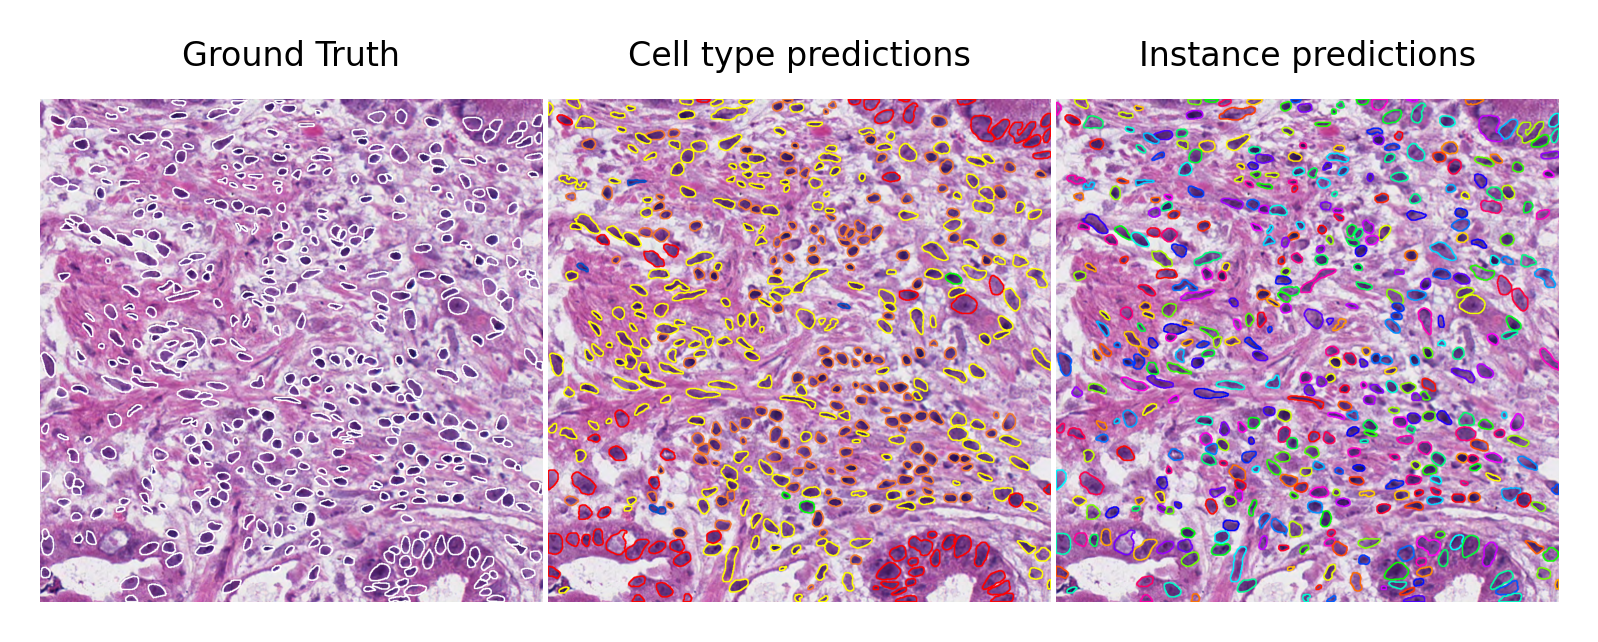

In [23]:
# VISUALIZE AND SAVE
fontsize = 6
j = 3
img_id = image_names[j]
plt.figure(dpi=400, facecolor="w", edgecolor="w")
plt.margins(0, 0)
plt.subplots_adjust(top=1, bottom=0, right=1, left=0.01, hspace=0, wspace=0.01)
plt.subplot(1, 5, 1)
true_regions = skimage.measure.regionprops(
    true_array[j, ..., 0], true_array[j, ..., 0] > 0
)
true_cell_type_dict = dict(
    map(
        lambda i, j: (i, j),
        [region.label for region in true_regions],
        [region.max_intensity for region in true_regions],
    )
)
plt.title("Ground Truth", fontsize = fontsize)
plt.imshow(
    vizutils.visualize_instances_map(
        inputs[j],
        true_array[j, ..., 0],
        true_cell_type_dict,
        type_colour={1: [255, 255, 255]},
        line_thickness=2,
    )
)
plt.gca().set_axis_off()
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())

plt.subplot(1, 5, 2)
regions = skimage.measure.regionprops(pred_array[j, ..., 0], pred_array[j, ..., 1])
pred_cell_type_dict = dict(
    map(
        lambda i, j: (i, j),
        [region.label for region in regions],
        [region.max_intensity for region in regions],
    )
)
plt.title("Cell type predictions", fontsize = fontsize)
plt.imshow(
    vizutils.visualize_instances_map(
        inputs[j],
        pred_array[j, ..., 0],
        pred_cell_type_dict,
        type_colour=DATASETMETA[configuration]["type_colour"],
        line_thickness=2,
    )
)
plt.gca().set_axis_off()
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())

plt.subplot(1, 5, 3)
plt.title("Instance predictions", fontsize = fontsize)
plt.imshow(
    vizutils.visualize_instances_map(
        inputs[j],
        pred_array[j, ..., 0],
        line_thickness=2,
    )
)
plt.gca().set_axis_off()
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.savefig(os.path.join(output_folder,img_id + ".png"), bbox_inches="tight", pad_inches=0)

### APPLY TO WSI (WIP)
The following section needs review (but it gives an idea of how the model can be applied to WSI)!

In [ ]:
import skimage
import pickle
import cv2
from skimage.measure import label
from cisca.visualization import visualize_instances_map, plotandsave
from cisca.augmentation import stain_normalization
from cisca.augmentation.transforms import stain_normalizersNISSLaug

rootfolder = "D:/NucleiSegmentation/Projects/cytoark/datasets"
predict_inputoutput_folder = "E:/FromPadova/H&E/Korat"

# # optional - to apply stain normalization and match the stain appearance of a target image
# fullname1 = os.path.join(rootfolder, "extra/Nissl", "1-scimpanze-1dx-2sx_1_slice_1.png")
# target_image1 = cv2.cvtColor(cv2.imread(fullname1, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
# stain_normalizer = stain_normalization.VahadaneNormalizer()
# stain_normalizer.fit(target_image1)

watershed_line = False

imageslist = [
    "AJ917_28E_016_ROI",
    "controllo_1_AJ917_28E_016_ROI",
    "controllo_2_22118_2_016_ROI",
    "controllo_3_54269_28E_016_ROI",
]

for imageid in imageslist:
    image_input = os.path.join(predict_inputoutput_folder, imageid + ".png")
    print(image_input)
    image_016_ROI = cv2.cvtColor(
        cv2.imread(image_input, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB
    )

    normed_sample = stain_normalizersNISSLaug[2].transform(image_016_ROI)

    filepath = os.path.join(predict_inputoutput_folder, imageid + "_output.pickle")
    print(filepath)
    cell_instances, n_cells = ciscamodel.predict(
        np.expand_dims(normed_sample / 255, 0),
        watershed_line=watershed_line,
        save_pred=True,
        filepath=filepath,
    )

    with open(os.path.join(predict_inputoutput_folder, imageid + ".pickle"), "wb") as handle:
        pickle.dump(
            {"cell_instances": cell_instances, "n_cells": n_cells},
            handle,
            protocol=pickle.HIGHEST_PROTOCOL,
        )

    # print(n_cells)

# uncomment to save 6 images with predictions for single classes
# plotandsave(input_img,imageid,cell_instances,cell_type,cell_type_dict,ciscmodel.predict_folder,foldername,GTpath)
